# Facial Pain Analyses

This notebook contains code for performing descriptive and ML-based analyses of demographics and clinical characteristics. The data was pulled from patients who were seen between 2013-2024 and had completed the clinical questionnaires of interest (Columbia-Suicide Severity Rating Scale and Brief Pain Inventory-Facial). 

---
> Justin Campbell, PhD (justin.campbell@hsc.utah.edu)  
> Version: 05/20/25

## Setup Notebook

In [12]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Rectangle
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [13]:
# Notebook settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Import Data

In [14]:
# Set directories
proj_dir = '/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/FacialPain'
data_dir = os.path.join(proj_dir, 'Data')

In [15]:
# Load the data
df = pd.read_csv(os.path.join(data_dir, 'TN Dataset 041725.csv'))

### 1.1 Data Cleaning

In [16]:
# Re-map the ICD codes to a more manageable format
ICD_map = {'ATYPICAL FACIAL PAIN': 'AFP',
        'ATYPICAL FACE PAIN': 'AFP',
        'CLONIC HEMIFACIAL SPASM': 'HFS',
        'MULTIPLE SCLEROSIS': 'MS',
        'TRIGEMINAL NEURALGIA': 'TN',
        'CHRONIC PAIN DUE TO TRAUMA': 'Posttraumatic',
        'POSTHERPETIC TRIGEMINAL NEURALGIA': 'PHTN',
        'OTH TRIGEMINAL AUTONOM CEPHALGIAS INTRACTABLE ': 'Other',
        'OTH TRIGEMINAL AUTONOM CEPHALGIAS NOT INTRACT': 'Other',
        'OTHER TRIGEMINAL AUTONOM CEPHALGIAS ': 'Other',
        'OTHER DISORDERS OF TRIGEMINAL NERVE': 'Other',
        'OTHER SPECIFIED TRIGEMINAL NERVE DISORDERS': 'Other',
        'OTHER FACIAL NERVE DISORDERS': 'Other'}
df['ICD_Clean'] = df['D_ICD_DESC'].map(ICD_map)
df['ICD_TN'] = df['ICD_Clean'].apply(lambda x: 1 if x == 'TN' else 0)

# Re-map C-SRSS to a more manageable format
CSRSS_map = {'No': 0, 'Yes': 1}
df['CSRSS_Thoughts'] = df['IP_R_NEU_CSSRS_SUICIDAL_THOUGHTS'].map(CSRSS_map)
df['CSRSS_Behaviors'] = df['IP_R_SW_CSSRS_SUICIDAL_BEHAVIOR'].map(CSRSS_map)

In [17]:
# Restructure CSRSS data
df['CSRSS_Either'] = df[['CSRSS_Thoughts', 'CSRSS_Behaviors']].sum(axis=1, skipna=True)
df['CSRSS_Either'] = df['CSRSS_Either'].apply(lambda x: 1 if x > 0 else 0)

## 2. Descriptive Analyses

### 2.1 Demographics

In [18]:
# Unique patients
n_patients = len(df['PAT_ID'].unique())

# Remove duplicate patients (keep first admission)
# demographic_df = df.copy()
# demographic_df = demographic_df.sort_values('CODE_SEQNUM', ascending = True) # 1 for initial visit, 2 for subsequent visit, ...
# demographic_df = demographic_df.drop_duplicates(subset = 'PAT_ID') # keep first visit

In [19]:
# Age (at admission)
df['ADM_DATE'] = pd.to_datetime(df['ADM_DATE'], format = "%m/%d/%y")
df['AGE'] = df['age']

# Sex
n_female = len(df[df['D_GENDER_DESC'] == 'Female'])

# Race
race_counts = df['D_RACE_DESC'].value_counts().to_string()

# Ethnicity
ethnicity_counts = df['D_ETHNICITY_DESC'].value_counts().to_string()

# Insurance status
insurance_counts = df['D_FINAN_CLASS_DESC'].value_counts().to_string()

# ICD Dx
dx_counts = df['ICD_Clean'].value_counts().to_string()

# Burden of illness
# Convert Onset_Clean to datetime
df['Onset_Clean'] = pd.to_datetime(df['Onset_Clean'], format = "%m/%d/%y")
df['Duration'] = (df['ADM_DATE'] - df['Onset_Clean']).dt.days
df['Duration_Yrs'] = df['Duration'] / 365.25


In [20]:
# Display descriptives
print('Descriptives Summmary:')
print('\n')

print('# Entries: %i' %df.shape[0])
print('# Unique Patients: %i' %n_patients)
print('# Females: %i (%.1f%%)' %(n_female, (n_female/n_patients)*100))
print('Mean (SD) Age: %.1f years (±%.1f), Range: %.1f-%.1f' %(df['AGE'].mean(), df['AGE'].std(), df['AGE'].min(), df['AGE'].max()))
print('Date Range: %s - %s' %(df['ADM_DATE'].min().strftime('%m/%d/%Y'), df['ADM_DATE'].max().strftime('%m/%d/%Y')))
print('\n')

print('Race:')
print(race_counts)
print('\n')

print('Ethnicity:')
print(ethnicity_counts)
print('\n')

print('Insurance Status:')
print(insurance_counts)
print('\n')

print('ICD Diagnosis:')
print(dx_counts)
print('\n')

print('Burden of Illness:')
print('Median (IQR) Duration: %.1f (%.1f-%.1f) years' %(df['Duration_Yrs'].median(), df['Duration_Yrs'].quantile(0.25), df['Duration_Yrs'].quantile(0.75)))

Descriptives Summmary:


# Entries: 181
# Unique Patients: 181
# Females: 124 (68.5%)
Mean (SD) Age: 58.4 years (±18.2), Range: 15.0-90.0
Date Range: 07/17/2020 - 09/26/2024


Race:
D_RACE_DESC
White or Caucasian                               152
Hispanic/Latino/a/x-Other Hispanic/Latino/a/x     13
Choose not to disclose                             4
Unreported/Refused to Report                       4
American Indian and Alaska Native                  3
Black or African American                          2
Native Hawaiian and Other Pacific Islander         2


Ethnicity:
D_ETHNICITY_DESC
Not Hispanic/Latino                  157
Hispanic/Latino                       12
Unknown/Information Not Available      4
Choose not to disclose                 3


Insurance Status:
D_FINAN_CLASS_DESC
UT MEDICARE           86
UT COMMERCIAL         80
UT MEDICAID           10
UT MISC GOVERNMENT     3
Self-Pay               2


ICD Diagnosis:
ICD_Clean
TN       142
AFP       16
Other     12
MS         

### 2.2 C-SRSS Responses

In [21]:
# Subset patients who responded to either suicidal behavior or suicidal thoughts question
CSSRS_behavior = df[~df['IP_R_SW_CSSRS_SUICIDAL_BEHAVIOR'].isna()]
CSSRS_thoughts = df[~df['IP_R_NEU_CSSRS_SUICIDAL_THOUGHTS'].isna()]
CSRSS_either = df[~df['CSRSS_Either'].isna()]

# Display patients w/ suicidal behavior or thoughts
print(df['CSRSS_Behaviors'].value_counts().to_string())
print('Proportion: %.1f%%' %(df['CSRSS_Behaviors'].mean()*100))
print('\n')

print(df['CSRSS_Thoughts'].value_counts().to_string())
print('Proportion: %.1f%%' %(df['CSRSS_Thoughts'].mean()*100))
print('\n')

print(df['CSRSS_Either'].value_counts().to_string())
print('Proportion: %.1f%%' %(df['CSRSS_Either'].mean()*100))

CSRSS_Behaviors
0.0    67
1.0    13
Proportion: 16.2%


CSRSS_Thoughts
0    162
1     19
Proportion: 10.5%


CSRSS_Either
0    157
1     24
Proportion: 13.3%


In [22]:
# Run Chi-square test for independence (gender x CSRSS-either)
csrss_counts_gender = df.groupby('D_GENDER_DESC')['CSRSS_Either'].value_counts().values
csrss_counts_gender = csrss_counts_gender.reshape(2, 2)
chi2, p, dof, expected = chi2_contingency(csrss_counts_gender)
print('Gender x CSRSS-Either')
print('Chi2: %.3f, p = %.3f' %(chi2, p))
print('')

# Run Chi-square test for independence (ICD-TN x CSRSS-either)
csrss_counts_tn = df.groupby('ICD_TN')['CSRSS_Either'].value_counts().values
csrss_counts_tn = csrss_counts_tn.reshape(2, 2)
chi2, p, dof, expected = chi2_contingency(csrss_counts_tn)
print('ICD-TN x CSRSS-Either')
print('Chi2: %.3f, p = %.3f' %(chi2, p))

Gender x CSRSS-Either
Chi2: 2.082, p = 0.149

ICD-TN x CSRSS-Either
Chi2: 0.031, p = 0.861


### 2.3 BPI-Facial Responses

In [23]:
# BPI-Facial cols
amb_painintensity = ['CIRCLE_THE_ONE_NUMBER_THAT_DESCRIBES_YOUR_PAIN_RIGHT_NOW','AMB_NSR_R_PAIN_AT_ITS_WORST_IN_LAST_WEEK','AMB_NSR_R_PAIN_AT_ITS_LEAST_IN_LAST_WEEK', 'AMB_NSR_R_PAIN_AT_ITS_AVERAGE_IN_LAST_WEEK']
amb_interference = ['AMB_NSR_R_GENERAL_ACTIVITY', 'AMB_NSR_R_MOOD', 'AMB_NSR_R_NORMAL_WORK', 'AMB_NSR_R_RELATIONS_WITH_OTHER_PEOPLE','AMB_NSR_R_SLEEP', 'AMB_NSR_R_ENJOYMENT_OF_LIFE']
amb_specific = ['AMB_NSR_R_EATING_A_MEAL', 'AMB_NSR_R_TOUCHING_YOUR_FACE', 'AMB_NSR_R_BRUSHING_OR_FLOSSING_YOUR_TEETH', 'AMB_NSR_R_SMILING_OR_LAUGHING', 'AMB_NSR_R_TALKING', 'AMB_NSR_R_OPENING_YOUR_MOUTH_WIDELY','AMB_NSR_R_EATING_HARD_FOODS_LIKE_APPLES']
amb_any = amb_painintensity + amb_interference + amb_specific + ['AMB_NSR_R_BRIEF_PAIN_INVENTORY_FACIAL_SCORE']

# Get BPI-Facial total scores
amb_df = df[amb_any].copy()
amb_df_missing = amb_df[amb_df.isnull().any(axis=1)].index # flag any rows missing data in one of the BPI-Facial columns
amb_df = amb_df.drop(amb_df_missing) # drop rows with missing data
amb_total_scores = amb_df['AMB_NSR_R_BRIEF_PAIN_INVENTORY_FACIAL_SCORE']

# Get domain average over columns/questions
amb_painintensity_df = amb_df[amb_painintensity].copy()
amb_painintensity_df = amb_painintensity_df.mean(axis = 1, skipna = True)

amb_interference_df = amb_df[amb_interference].copy()
amb_interference_df = amb_interference_df.mean(axis = 1, skipna = True)

amb_specific_df = amb_df[amb_specific].copy()
amb_specific_df = amb_specific_df.mean(axis = 1, skipna = True)

# Get suicidal ideation status
is_sui = df.copy()
is_sui = is_sui.drop(amb_df_missing)
is_sui = is_sui['CSRSS_Either'].values

# Get TN status
is_tn = df.copy()
is_tn = is_tn.drop(amb_df_missing)
is_tn = is_tn['ICD_TN'].values

In [24]:
# report mean ± SD for each BPI-Facial domain
amb_painintensity_df = amb_painintensity_df.dropna()
amb_interference_df = amb_interference_df.dropna()
amb_specific_df = amb_specific_df.dropna()

print('BPI-Facial Scores (Combined):')
print('Pain Intensity: %.1f (± %.1f)' %(amb_painintensity_df.mean(), amb_painintensity_df.std()))
print('Interference (General): %.1f (± %.1f)' %(amb_interference_df.mean(), amb_interference_df.std()))
print('Interference (Face-Specific): %.1f (± %.1f)' %(amb_specific_df.mean(), amb_specific_df.std()))
print('Total: %.1f (± %.1f)' %(amb_total_scores.mean(), amb_total_scores.std()))

BPI-Facial Scores (Combined):
Pain Intensity: 4.8 (± 2.6)
Interference (General): 5.1 (± 3.1)
Interference (Face-Specific): 5.4 (± 3.5)
Total: 90.5 (± 50.4)


In [25]:
# Calculate BPI-Facial domain scores, split by CSRSS_Either, test for significance
painintensity_sui = amb_painintensity_df[is_sui == 1].values
painintensity_notsui = amb_painintensity_df[is_sui == 0].values
interference_sui = amb_interference_df[is_sui == 1].values
interference_notsui = amb_interference_df[is_sui == 0].values
specific_sui = amb_specific_df[is_sui == 1].values
specific_notsui = amb_specific_df[is_sui == 0].values

# Test for significance
painintensity_t, painintensity_p = stats.ttest_ind(painintensity_sui, painintensity_notsui)
interference_t, interference_p = stats.ttest_ind(interference_sui, interference_notsui)
specific_t, specific_p = stats.ttest_ind(specific_sui, specific_notsui)

print('BPI-Facial Scores (Split by C-SRSS):')
print('Pain Intensity: %.1f (± %.1f) vs. %.1f (± %.1f), t(%.0f) = %.2f, p = %.4f' %(painintensity_sui.mean(), painintensity_sui.std(), painintensity_notsui.mean(), painintensity_notsui.std(), len(painintensity_sui) + len(painintensity_notsui) - 2, painintensity_t, painintensity_p))
print('Interference (General): %.1f (± %.1f) vs. %.1f (± %.1f), t(%.0f) = %.2f, p = %.4f' %(interference_sui.mean(), interference_sui.std(), interference_notsui.mean(), interference_notsui.std(), len(interference_sui) + len(interference_notsui) - 2, interference_t, interference_p))
print('Interference (Face-Specific): %.1f (± %.1f) vs. %.1f (± %.1f), t(%.0f) = %.2f, p = %.4f' %(specific_sui.mean(), specific_sui.std(), specific_notsui.mean(), specific_notsui.std(), len(specific_sui) + len(specific_notsui) - 2, specific_t, specific_p))

BPI-Facial Scores (Split by C-SRSS):
Pain Intensity: 6.3 (± 1.6) vs. 4.6 (± 2.7), t(175) = 2.98, p = 0.0033
Interference (General): 7.2 (± 1.9) vs. 4.8 (± 3.2), t(175) = 3.48, p = 0.0006
Interference (Face-Specific): 6.7 (± 2.9) vs. 5.2 (± 3.5), t(175) = 1.91, p = 0.0573


## 3. Machine-Learning Analyses

### 3.1 Logistic Regression Classification

In [26]:
# Copy DF and removing rows with missing BPI-Facial data
ml_df = df.copy()
ml_df = ml_df.drop(amb_df_missing)

# Separate features and target
X = ml_df.drop(columns='CSRSS_Either')
y = ml_df['CSRSS_Either']

# Identify types of features
categorical_features = ['D_GENDER_DESC', 'ICD_TN']
continuous_features = ['AGE'] + amb_any # All BPI-Facial columns

# Preprocessing: one-hot for categoricals, scaling for numerics
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), continuous_features)
])

# Pipeline with SMOTE and Logistic Regression
pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('logreg', LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l2'))
])

# Train-test split
X = ml_df.drop(columns='CSRSS_Either')
y = ml_df['CSRSS_Either']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

# Fit model
pipeline.fit(X_train, y_train)

# Predict probabilities
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred_default = pipeline.predict(X_test)

# Report default threshold performance
print("Classification Report (Default Threshold):\n", classification_report(y_test, y_pred_default))
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5)
print(f"Cross-validated ROC AUC: {scores.mean():.2f} ± {scores.std():.2f}")

Classification Report (Default Threshold):
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        47
           1       0.23      0.43      0.30         7

    accuracy                           0.74        54
   macro avg       0.57      0.61      0.57        54
weighted avg       0.82      0.74      0.77        54

Cross-validated ROC AUC: 0.64 ± 0.05


### 3.2 K-Means Clustering

In [27]:
# Copy DF and removing rows with missing BPI-Facial data
ml_df = df.copy()
ml_df = ml_df.drop(amb_df_missing)
ml_df['Pain_Intensity'] = ml_df[amb_painintensity].sum(axis=1, skipna=True)
ml_df['Interference_General'] = ml_df[amb_interference].sum(axis=1, skipna=True)
ml_df['Interference_Face'] = ml_df[amb_specific].sum(axis=1, skipna=True)

# Define features
categorical_features = ['D_GENDER_DESC', 'ICD_TN', 'CSRSS_Either']
continuous_features = ['AGE', 'Pain_Intensity', 'Interference_General', 'Interference_Face']

# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), continuous_features)
])

# Create a pipeline
cluster_pipeline = make_pipeline(preprocessor, KMeans(n_clusters=2, random_state=0))

# Fit the model
cluster_pipeline.fit(ml_df)

# Get cluster labels
cluster_labels = cluster_pipeline.named_steps['kmeans'].labels_
ml_df['Cluster'] = cluster_labels

# View cluster sizes
print(ml_df['Cluster'].value_counts().to_string(), '\n')

# View average feature values per cluster
print(ml_df.groupby('Cluster')[['AMB_NSR_R_BRIEF_PAIN_INVENTORY_FACIAL_SCORE']].mean(), '\n')

# Cross-tab with diagnosis or suicidal ideation
print(pd.crosstab(ml_df['Cluster'], ml_df['ICD_TN']), '\n')
print(pd.crosstab(ml_df['Cluster'], ml_df['CSRSS_Either']), '\n')

# Get preprocessed data
X_transformed = preprocessor.fit_transform(ml_df)

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

Cluster
0    114
1     63 

         AMB_NSR_R_BRIEF_PAIN_INVENTORY_FACIAL_SCORE
Cluster                                             
0                                         122.403509
1                                          32.777778 

ICD_TN    0   1
Cluster        
0        29  85
1        10  53 

CSRSS_Either   0   1
Cluster             
0             94  20
1             60   3 



## 4. Figures

Fig. 1


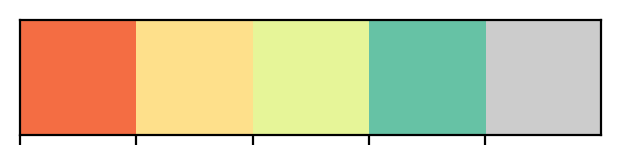

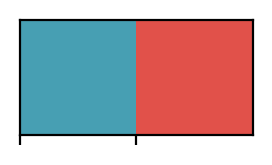

In [28]:
# Define figure palettes
palette_base = sns.color_palette('Spectral', 4)
palette_A = palette_base.copy()
palette_A.append((0.8, 0.8, 0.8))
palette_B = [sns.color_palette('Spectral',6)[-1], sns.color_palette('Spectral',6)[0]]
palette_C = [palette_base[0], palette_base[1], palette_base[2]]

print('Fig. 1')
sns.palplot(palette_A, size = 0.75)
sns.palplot(palette_B, size = 0.75)
plt.show()

# print('Fig. 2X')
# sns.palplot(palette_fig2, size = 0.75)

### Figure 1: Summary of facial pain etiology and responses to clinical questionnaires.

#### Fig. 1A: ICD Diagnosis Counts

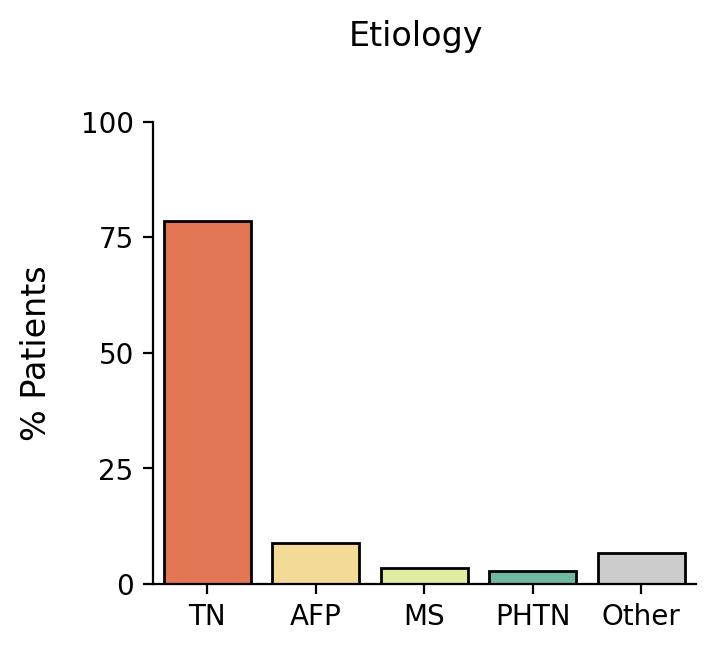

In [29]:
# Organize data
plot_df = df.copy()
order = plot_df.groupby('ICD_Clean').size().sort_values(ascending = False).index
order = order.tolist()
order.remove('Other')
order.append('Other')

# Plotting
fig, ax = plt.subplots(1,1, figsize=(3.5,3))
sns.countplot(x = 'ICD_Clean', data = plot_df, hue = 'ICD_Clean', stat = 'percent', order = order, hue_order = order, ax = ax, palette = palette_A, legend = False, saturation = 0.8)

# Aesthetics
plt.setp(ax.patches, linewidth = 1, edgecolor = 'k')
sns.despine(top  = True, right = True)
plt.xlabel('')
plt.ylabel('% Patients', fontsize = 'large', labelpad = 10)
plt.suptitle('Etiology', fontsize = 'large', y = 1.05)
plt.yticks(np.arange(0, 125, 25), fontsize = 'medium')
plt.ylim(0, 100)
plt.xticks(fontsize = 'medium')

# Export
plt.savefig(os.path.join(proj_dir, 'Results', 'ICD_Dx.pdf'), dpi = 1500, bbox_inches = 'tight')
plt.savefig(os.path.join(proj_dir, 'Results', 'ICD_Dx.png'), dpi = 1500, bbox_inches = 'tight')
plt.show()

#### Fig. 1B: Columbia-Suicide Severity Rating Scale

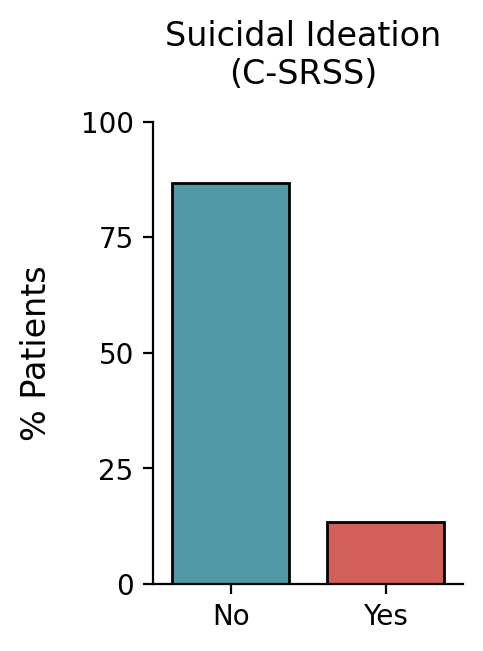

In [30]:
# Plotting
fig, ax = plt.subplots(1,1, figsize = (2, 3))
sns.countplot(x = 'CSRSS_Either', data = df, ax = ax, hue = 'CSRSS_Either', palette = palette_B, hue_order = [0, 1], saturation=.8, stat = 'percent', width = 0.75, legend = False)

# Aesthetics
plt.setp(ax.patches, linewidth = 1, edgecolor = 'k')
plt.suptitle('Suicidal Ideation\n(C-SRSS)', fontsize = 'large', y = 1.05)
sns.despine(top  = True, right = True)
plt.xlabel('')
plt.ylabel('% Patients', fontsize = 'large', labelpad = 10)
plt.yticks(np.arange(0, 125, 25), fontsize = 'medium')
plt.xticks([0,1], ['No', 'Yes'], fontsize = 'medium')
plt.xticks(fontsize = 'medium')

# Export
plt.savefig(os.path.join(proj_dir, 'Results', 'C-SSRS.pdf'), dpi = 1500, bbox_inches = 'tight')
plt.savefig(os.path.join(proj_dir, 'Results', 'C-SSRS.png'), dpi = 1500, bbox_inches = 'tight')
plt.show()

#### Fig. 1C: Brief Pain Inventory-Facial

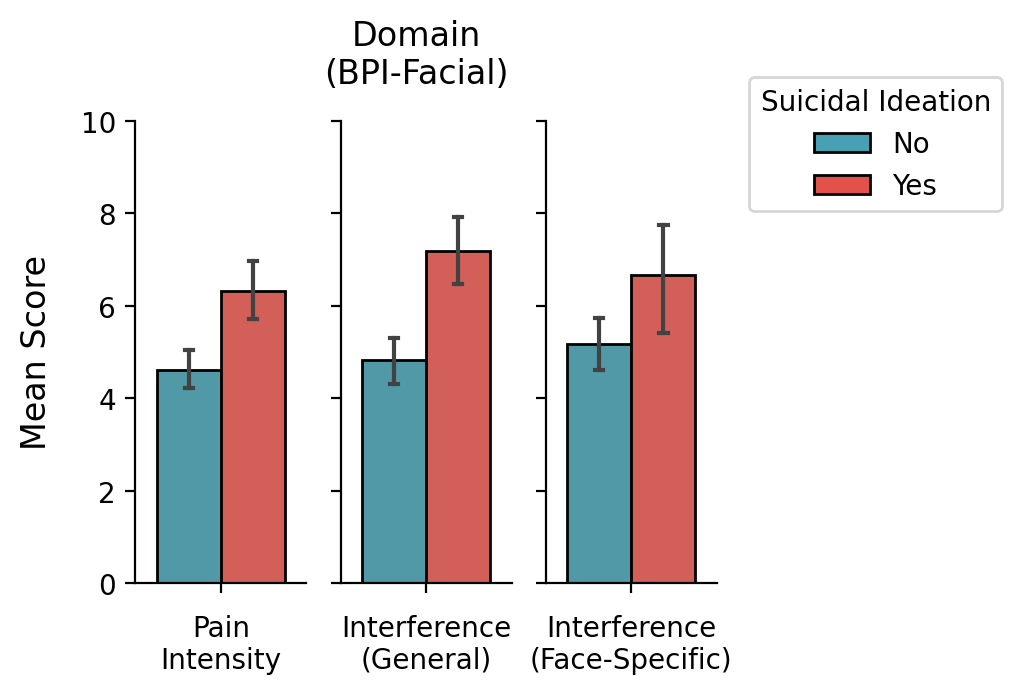

In [31]:
fig, axes = plt.subplots(1, 3, figsize = (3.75, 3), sharey = True)
sns.barplot(y = amb_painintensity_df, ax = axes[0], palette = palette_B, saturation=0.8, width = 0.75, capsize = 0.1, err_kws={'linewidth': 1.5}, hue = is_sui, legend = False)
sns.barplot(y = amb_interference_df, ax = axes[1], palette = palette_B, saturation=0.8, width = 0.75, capsize = 0.1, err_kws={'linewidth': 1.5}, hue = is_sui, legend = False)
sns.barplot(y = amb_specific_df, ax = axes[2], palette = palette_B, saturation=0.8, width = 0.75, capsize = 0.1, err_kws={'linewidth': 1.5}, hue = is_sui, legend = True)

# Aesthetics
for ax in axes:
    plt.setp(ax.patches, linewidth = 1, edgecolor = 'k')
sns.despine(top  = True, right = True)
axes[0].set_xlabel('Pain\nIntensity', fontsize = 'medium')
axes[0].set_ylabel('Mean Score', fontsize = 'large', labelpad = 10)
axes[1].set_xlabel('Interference\n(General)', fontsize = 'medium')
axes[2].set_xlabel('Interference\n(Face-Specific)', fontsize = 'medium')
axes[0].set_yticks(np.arange(0, 12, 2), [0, 2, 4, 6, 8, 10], fontsize = 'medium')
plt.suptitle('Domain\n(BPI-Facial)', fontsize = 'large', y = 1.05)

# Change legend labels
handles, labels = axes[2].get_legend_handles_labels()
handles[0].set_facecolor(palette_B[0])
handles[1].set_facecolor(palette_B[1])
axes[2].legend(handles, ['No', 'Yes'], title = 'Suicidal Ideation', title_fontsize = 'medium', fontsize = 'medium', loc = 'upper right', bbox_to_anchor=(2.75, 1.125))

# Export
plt.savefig(os.path.join(proj_dir, 'Results', 'BPIxCSRSS.pdf'), dpi = 1500, bbox_inches = 'tight')
plt.savefig(os.path.join(proj_dir, 'Results', 'BPIxCSRSS.png'), dpi = 1500, bbox_inches = 'tight')
plt.show()

In [32]:
# # Plotting
# fig, axes = plt.subplots(1, 3, figsize = (3.75, 3), sharey = True)
# sns.barplot(y = amb_painintensity_df, ax = axes[0], color = palette_C[0], saturation=0.8, width = 0.75, capsize = 0.1, err_kws={'linewidth': 1.5})
# sns.barplot(y = amb_interference_df, ax = axes[1], color = palette_C[1], saturation=0.8, width = 0.75, capsize = 0.1, err_kws={'linewidth': 1.5})
# sns.barplot(y = amb_specific_df, ax = axes[2], color = palette_C[2], saturation=0.8, width = 0.75, capsize = 0.1, err_kws={'linewidth': 1.5})

# # Aesthetics
# for ax in axes:
#     plt.setp(ax.patches, linewidth = 1, edgecolor = 'k')
# sns.despine(top  = True, right = True)
# axes[0].set_xlabel('Pain\nIntensity', fontsize = 'medium')
# axes[0].set_ylabel('Mean Score', fontsize = 'large', labelpad = 10)
# axes[1].set_xlabel('Interference\n(General)', fontsize = 'medium')
# axes[2].set_xlabel('Interference\n(Face-Specific)', fontsize = 'medium')
# axes[0].set_yticks(np.arange(0, 12, 2), [0, 2, 4, 6, 8, 10], fontsize = 'medium')
# plt.suptitle('Domain\n(BPI-Facial)', fontsize = 'large', y = 1.05)

# # Export
# plt.savefig(os.path.join(proj_dir, 'Results', 'BPI.pdf'), dpi = 1500, bbox_inches = 'tight')
# plt.savefig(os.path.join(proj_dir, 'Results', 'BPI.png'), dpi = 1500, bbox_inches = 'tight')
# plt.show()

### Exploratory

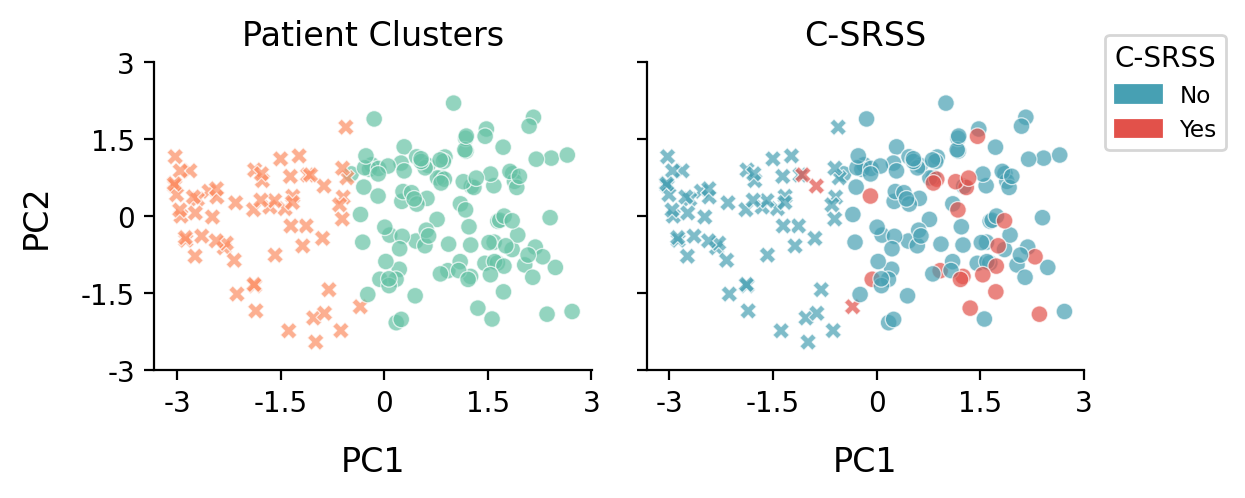

In [33]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(6, 2), sharey= True)
fig.subplots_adjust(wspace=0.125)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=ml_df['Cluster'], style = ml_df['Cluster'], palette='Set2', ax = axes[0], alpha=0.7, legend = False)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=ml_df['CSRSS_Either'], style = ml_df['Cluster'], palette=palette_B, ax = axes[1], alpha=0.7, legend = False)

axes[0].set_title('Patient Clusters')
axes[1].set_title('C-SRSS')

for ax in fig.axes:
    ax.set_xlabel('PC1', fontsize = 'large', labelpad = 10)
    ax.set_ylabel('PC2', fontsize = 'large', labelpad = 10)
    ax.set_xticks(np.arange(-3, 4.5, 1.5), ['-3', '-1.5', '0', '1.5', '3'], fontsize = 'medium')
    ax.set_yticks(np.arange(-3, 4.5, 1.5), ['-3', '-1.5', '0', '1.5', '3'], fontsize = 'medium')
    sns.despine(ax=ax, top=True, right=True)
    
# Create legend with just yes/no
labels = ['No', 'Yes']
handles = [Rectangle((0,0), 1, 1, color=palette_B[0]), Rectangle((0,0), 1, 1, color=palette_B[1])]
axes[1].legend(handles, labels, title = 'C-SRSS', title_fontsize = 'medium', fontsize = 'small', loc = 'upper right', bbox_to_anchor=(1.35, 1.125))


# Export
plt.savefig(os.path.join(proj_dir, 'Results', 'CSRSS_Clusters.pdf'), dpi = 1500, bbox_inches = 'tight')
plt.savefig(os.path.join(proj_dir, 'Results', 'CSRSS_Clusters.png'), dpi = 1500, bbox_inches = 'tight')
plt.show()